In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from tensorflow.keras.applications import EfficientNetB4

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
efficienNet = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(256,256,3))

In [4]:
print(efficienNet.layers[326].output.shape)
print(efficienNet.layers[149].output.shape)
print(efficienNet.layers[90].output.shape)
print(efficienNet.layers[31].output.shape)

(None, 16, 16, 960)
(None, 32, 32, 336)
(None, 64, 64, 192)
(None, 128, 128, 144)


# Modelo
https://www.nature.com/articles/s41598-022-12743-y/figures/2

In [5]:
def encoder_subblock(efNet_conection_output):
    x = layers.Conv2D(512,3, padding = 'same')(efNet_conection_output)
    x = residual_block(x)
    x = residual_block(x)
    x = layers.LeakyReLU()(x)
    return x


def efNet_conection(efNet_output):
    x1 = layers.LeakyReLU()(efNet_output)
    x2 = layers.MaxPool2D((2,2), padding = 'same')(x1)
    x3 = layers.Dropout(0.3)(x2)
    return x3


def decoder_subblock(encoder_output, prev_layer):
    # https://www.nature.com/articles/s41598-022-12743-y/figures/3
    unification = layers.concatenate([encoder_output, prev_layer])
    x1 = layers.Dropout(0.3)(unification)
    x2 = layers.Conv2D(3,3,padding = 'same')(x1)
    x3 = residual_block(x2)
    x3 = residual_block(x3)
    x4 = layers.LeakyReLU()(x3)
    return x4


def residual_block(prev_layer):
    path_1 = layers.LeakyReLU()(prev_layer)
    path_1 = layers.BatchNormalization()(path_1)
    path_1 = layers.Conv2D(3,3,padding = 'same')(path_1)
    path_1 = layers.BatchNormalization()(path_1)
    path_1 = layers.LeakyReLU()(path_1)
    path_1 = layers.Conv2D(3,3,padding = 'same')(path_1)
    path_1 = layers.BatchNormalization()(path_1)
    path_2 = layers.BatchNormalization()(prev_layer)
    return layers.concatenate([path_1, path_2])

    
def up_sampling(prev_layer, deep, kernel):
    x = layers.Conv2DTranspose(deep, kernel)(prev_layer)
    return x


def last_up_sampling(prev_layer):
    x = layers.Conv2D(1,3, padding='same', activation='sigmoid')(prev_layer)
    return x


No me deja añadir una capa inicial, porque sino efficienNet da error, necesita recibir un input.layer, sino cuando carga los pesoss dice que las capas no coinciden.

No he añadido el encoder sub block porque me da error

In [6]:
def build_unet_model():
     # inputs
    inputs = layers.Input(shape=(256,256,3))
    
    # adaptation = layers.Conv2D(3, 3, padding="same", activation = "elu")(inputs)
        
    #EfficientNet
    efficienNet = EfficientNetB4(weights="imagenet",
                                 include_top=False,
                                 input_shape=(256,256,3),
                                 input_tensor=inputs)
    
    efficienNet.trainable = False
    
    # ENCONDING
    # (128,128,144)
    dw1 = efficienNet.layers[31].output
    # (64,64,192)
    dw2 = efficienNet.layers[90].output
    # (32,32,336)
    dw3 = efficienNet.layers[149].output
    # (16,16,960)
    dw4 = efficienNet.layers[326].output

    # (8,8,960)
    middle = efNet_conection(dw4)
    # Encoder sub block (no la he añadido porque me da error)
    middle = encoder_subblock(middle)
    
    # DECODING
    # (16,16,960)
    uc1 = up_sampling(middle, dw4.shape[3],9)
    up1 = decoder_subblock(dw4, uc1)
    
    # (32,32,336)
    uc2 = up_sampling(up1, dw3.shape[3],17)
    up2 = decoder_subblock(dw3, uc2)
    
    # (64,64,192)
    uc3 = up_sampling(up2, dw2.shape[3],33)
    up3 = decoder_subblock(dw2, uc3)
    
    # (128,128,144)
    uc4 = up_sampling(up3,dw3.shape[3],65)
    up4 = decoder_subblock(dw1, uc4)

    uc5 = up_sampling(up4,16,129)

    # outputs
    outputs = last_up_sampling(uc5)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [7]:
unet_model = build_unet_model()

In [8]:
len(unet_model.layers)

444

**Añado una capa inicial**

Para poder poner el input de 1 canal hago un modelo secuencial con una primera capa y el unet-model

In [9]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(3,3,padding="same", input_shape=(256,256,1), activation='elu', name = 'conv_inicial'))
model.add(unet_model)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_inicial (Conv2D)        (None, 256, 256, 3)       30        
_________________________________________________________________
U-Net (Functional)           (None, 256, 256, 1)       66608015  
Total params: 66,608,045
Trainable params: 62,761,586
Non-trainable params: 3,846,459
_________________________________________________________________


**Capas a entrenar**

Vamos a entrenar la primera capa y a partir de la capa 327 de unet-model, que es la ultima del modelo preentrenado

In [11]:
fine_tune_at = 327

for layer in unet_model.layers[1:327]:
    layer.trainable = False

In [12]:
len(model.trainable_variables)

144

# Datos

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Datos

In [14]:
# path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'
path = '/home/mr1142/Documents/Data/seg_prueba'

In [15]:
masks_name = os.listdir(os.path.join(path, 'mascara'))

In [16]:
pixels = 256

In [17]:
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [18]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)

In [19]:
def binarize(img):
    img[img>0] = 1
    return img

In [20]:
masks = np.zeros((len(masks_name), pixels,pixels,1))
print(masks.shape)
for i in range(len(masks_name)):
    masks[i, ...] = binarize(read_img(path, 'mascara', masks_name[i]))

(80, 256, 256, 1)


In [21]:
images = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    images[i, ...] = normalize(read_img(path, 'images', masks_name[i]))

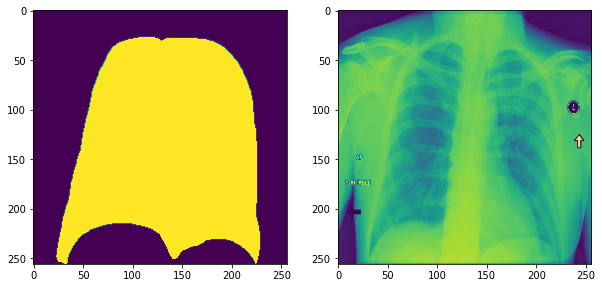

In [22]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(masks[r])
plt.subplot(1,2,2)
plt.imshow(images[r])
plt.show()

In [23]:
images.shape

(80, 256, 256, 1)

## Selección de pesos por imagen

Vamos a ver las imagenes y elegir las de peor calidad para darles más peso

In [24]:
# for i in range(len(images)):
#     print(i)
#     plt.figure(figsize=(100, 100))
#     plt.subplot(1,len(images),i+1)
#     plt.imshow(images[i])
#     plt.show()

In [25]:
# bad_quality = [14,15,34] + [i for i in range(39,56)] + [65,73,76,77]

In [26]:
# importance = np.array([1 if i in bad_quality else 0.75 for i in range(len(images))])

# Aumento de datos

In [27]:
import imutils

In [28]:
def augment(input_image, input_mask):
    r = np.random.randint(-60,60)
    # Random flipping of the image and mask
    input_image = np.expand_dims(imutils.rotate(input_image, angle=r),  axis=-1)
    input_mask = np.expand_dims(imutils.rotate(input_mask, angle=r), axis=-1)
    input_mask = binarize(input_mask)
    return input_image, input_mask

Nuevas imagenes con rotacion random

In [29]:
new_img = np.zeros((len(masks_name), pixels,pixels,1))
new_mask = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    img, mask = augment(images[i], masks[i])
    new_img[i, ...] = img
    new_mask[i,...] = mask

In [30]:
images = np.concatenate((new_img, images), axis = 0)
masks = np.concatenate((new_mask, masks), axis = 0)
# importance = np.concatenate((importance, importance), axis=0)

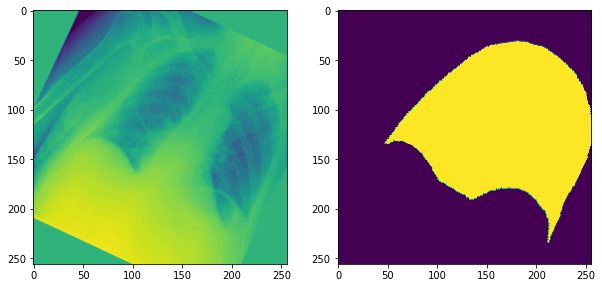

In [31]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(images[r])
plt.subplot(1,2,2)
plt.imshow(masks[r])
plt.show()

In [32]:
images.shape

(160, 256, 256, 1)

In [33]:
masks.shape

(160, 256, 256, 1)

# Entrenamiento

In [34]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=dice_coef_loss,
                  metrics=dice_coef)

In [36]:
batch = 8
epoch = 500

In [ ]:
history = model.fit(images,masks,
                    batch_size = batch,
                    epochs = epoch,
                    shuffle = True,
                    # sample_weight = importance,
                    validation_split = 0.2)

Epoch 1/500
16/16 [==============================] - 1045s 2s/step - loss: 0.3754 - dice_coef: 0.6246 - val_loss: 0.3065 - val_dice_coef: 0.6935
Epoch 2/500
16/16 [==============================] - 29s 2s/step - loss: 0.2056 - dice_coef: 0.7944 - val_loss: 0.2786 - val_dice_coef: 0.7214
Epoch 3/500
16/16 [==============================] - 30s 2s/step - loss: 0.1725 - dice_coef: 0.8275 - val_loss: 0.2259 - val_dice_coef: 0.7741
Epoch 4/500
16/16 [==============================] - 30s 2s/step - loss: 0.1667 - dice_coef: 0.8333 - val_loss: 0.1952 - val_dice_coef: 0.8048
Epoch 5/500
16/16 [==============================] - 30s 2s/step - loss: 0.1602 - dice_coef: 0.8398 - val_loss: 0.1741 - val_dice_coef: 0.8259
Epoch 6/500
16/16 [==============================] - 30s 2s/step - loss: 0.1560 - dice_coef: 0.8440 - val_loss: 0.1721 - val_dice_coef: 0.8279
Epoch 7/500
16/16 [==============================] - 30s 2s/step - loss: 0.1531 - dice_coef: 0.8469 - val_loss: 0.1748 - val_dice_coef: 0.82